In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()

sys.path.append(str(config.REPO_ROOT))

In [3]:
from python.src.preprocess import (
    preprocess_bike_data,
)
df_bike = pd.read_csv(config.data_dir / "bike+sharing+dataset" / "day.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

In [6]:
bike_features_of_interest = [
    "season",
    "holiday",
    "workingday",
    "weathersit",
    "temp",
    "hum",
    "windspeed",
    "days_since_2011",
]

X = df_bike_processed[bike_features_of_interest]
y = df_bike_processed["cnt"]
dat = pd.concat([X, y], axis=1)
model_formula = "cnt ~ " + " + ".join(bike_features_of_interest)
mod = ols(model_formula, data=dat).fit()
lm_summary = mod.summary2().tables[1]
lm_summary["t value"] = np.abs(lm_summary["t"])

lm_summary = lm_summary.rename(index={"Intercept": "Intercept"})
lm_summary_print = lm_summary[["Coef.", "Std.Err.", "t value"]].rename(
    columns={"Coef.": "Weight", "Std.Err.": "SE", "t value": "|t|"}
)
lm_summary_print = lm_summary_print.round(1)

display(lm_summary_print)

,Weight,SE,|t|
Intercept,2399.4,238.3,10.1
season[T.SPRING],899.3,122.3,7.4
season[T.SUMMER],138.2,161.7,0.9
season[T.FALL],425.6,110.8,3.8
holiday[T.HOLIDAY],-686.1,203.3,3.4
workingday[T.WORKING DAY],124.9,73.3,1.7
weathersit[T.MISTY],-379.4,87.6,4.3
weathersit[T.RAIN/SNOW/STORM],-1901.5,223.6,8.5
temp,110.7,7.0,15.7
hum,-17.4,3.2,5.5


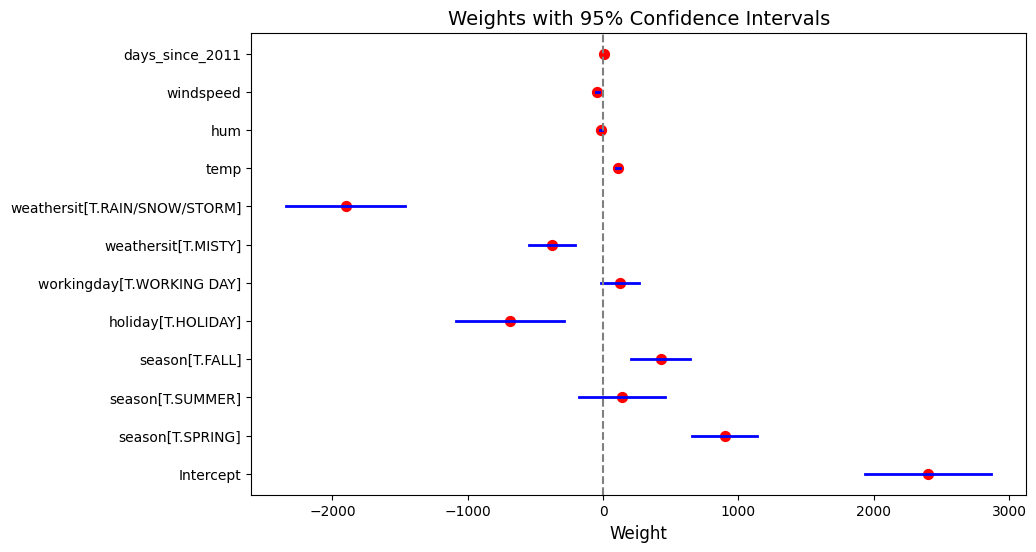

In [7]:
# Weight Plot
coefs = lm_summary["Coef."]
errors = lm_summary["Std.Err."]
lower_bounds = coefs - 1.96 * errors
upper_bounds = coefs + 1.96 * errors

plt.figure(figsize=(10, 6))

for i, (lower, upper, coef) in enumerate(zip(lower_bounds, upper_bounds, coefs)):
    plt.plot([lower, upper], [i, i], color="blue", linewidth=2)
    plt.scatter(coef, i, color="red", s=50)

plt.axvline(0, linestyle="--", color="gray")
plt.xlabel("Weight", fontsize=12)
plt.title("Weights with 95% Confidence Intervals", fontsize=14)
plt.yticks(range(len(coefs)), lm_summary.index)
plt.show()

In [8]:
X_dummies = pd.get_dummies(
    X, columns=["season", "holiday", "workingday", "weathersit"], drop_first=True
)
X_dummies = X_dummies.rename(
    columns={
        "season_SPRING": "season[T.SPRING]",
        "season_SUMMER": "season[T.SUMMER]",
        "season_FALL": "season[T.FALL]",  # 冬(1)が基準
        "holiday_HOLIDAY": "holiday[T.HOLIDAY]",  # 非休日(0)が基準
        "workingday_WORKING DAY": "workingday[T.WORKING DAY]",  # 非労働日(0)が基準
        "weathersit_MISTY": "weathersit[T.MISTY]",
        "weathersit_RAIN/SNOW/STORM": "weathersit[T.RAIN/SNOW/STORM]",  # 晴れ(1)が基準
    }
)
X_dummies[
    [
        "season[T.SPRING]",
        "season[T.SUMMER]",
        "season[T.FALL]",
        "holiday[T.HOLIDAY]",
        "workingday[T.WORKING DAY]",
        "weathersit[T.MISTY]",
        "weathersit[T.RAIN/SNOW/STORM]",
    ]
] = X_dummies[
    [
        "season[T.SPRING]",
        "season[T.SUMMER]",
        "season[T.FALL]",
        "holiday[T.HOLIDAY]",
        "workingday[T.WORKING DAY]",
        "weathersit[T.MISTY]",
        "weathersit[T.RAIN/SNOW/STORM]",
    ]
].astype(int)

In [9]:
df_effect = (X_dummies * mod.params).dropna(axis=1, how="all")
season_cols = [col for col in df_effect.columns if col.startswith("season[T.")]
df_effect["season"] = df_effect[season_cols].sum(axis=1)
df_effect = df_effect.drop(columns=season_cols)
weathersit_cols = [col for col in df_effect.columns if col.startswith("weathersit[T")]
df_effect["weathersit"] = df_effect[weathersit_cols].sum(axis=1)
df_effect = df_effect.drop(columns=weathersit_cols)
df_effect = df_effect.rename(
    columns={
        "workingday[T.WORKING DAY]": "workingday",
        "holiday[T.HOLIDAY]": "holiday",
    }
)

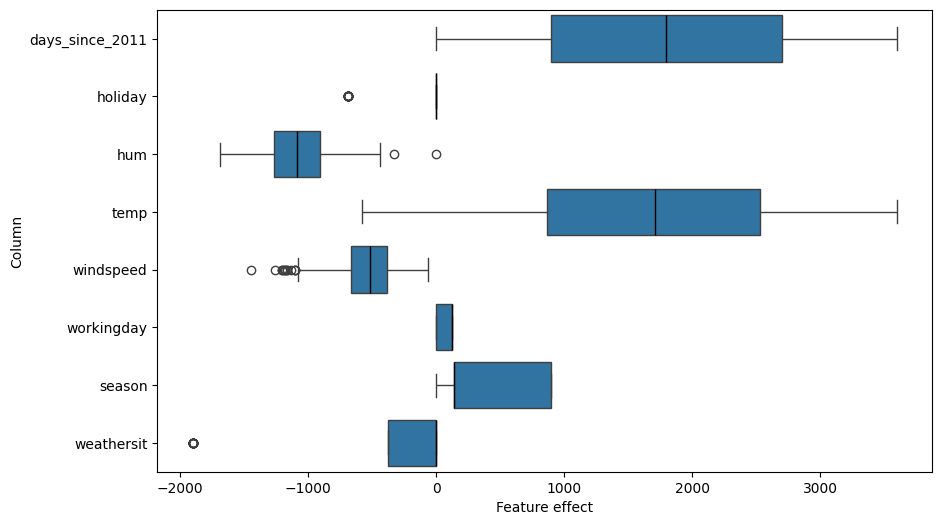

In [10]:
df_melted = df_effect.melt(var_name="Column", value_name="Value")
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Value",
    y="Column",
    data=df_melted,
    medianprops=dict(color="black"),
)
plt.xlabel("Feature effect")
plt.show()

In [11]:
dat.iloc[5]

season                  WINTER
holiday             NO HOLIDAY
workingday         WORKING DAY
weathersit                GOOD
temp                  1.604356
hum                    51.8261
windspeed             6.000868
days_since_2011              5
cnt                       1606
Name: 5, dtype: object

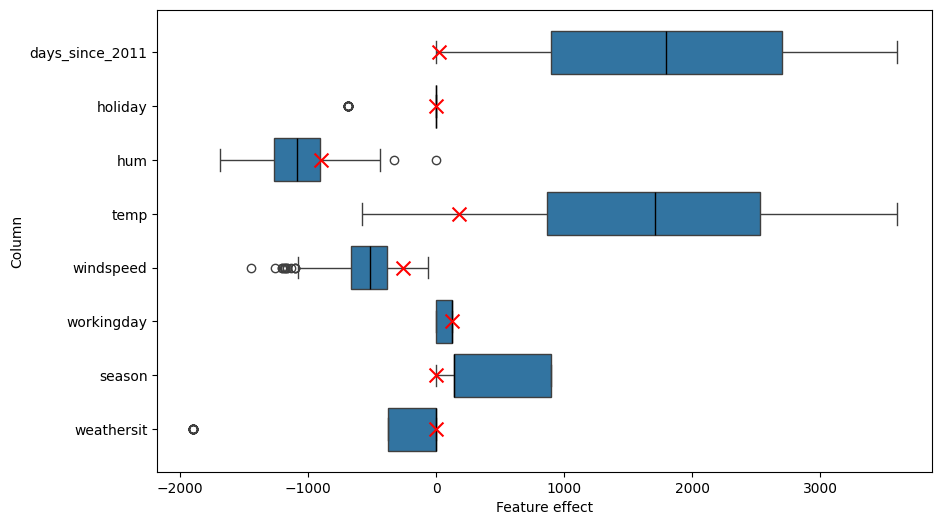

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Value",
    y="Column",
    data=df_melted,
    medianprops=dict(color="black"),
)
for col in df_effect.columns:
    plt.scatter(
        df_effect.iloc[5][col], col, marker="x", color="red", s=100, zorder=10
    )  # zorderで前面に
plt.xlabel("Feature effect")
plt.show()

In [13]:
df_effect["predict"] = df_effect.sum(axis=1) + mod.params["Intercept"]

print(f"Predicted value for instance 6: {int(df_effect.iloc[5]['predict'])}")
print(f"Average predicted value:{int(df_effect['predict'].mean())}")
print(f"Actual value:{dat.iloc[5]['cnt']}")

Predicted value for instance 6: 1570
Average predicted value:4504
Actual value:1606


In [14]:
# TODO
# 若干値が異なる．sklearnではなく，statsmodelで行うと整合性取れる可能性あり
# Lasso
X_dummies = pd.get_dummies(
    X, columns=["season", "holiday", "workingday", "weathersit"], drop_first=False
)

In [15]:
X_dummies = X_dummies.rename(
    columns={
        "season_SPRING": "seasonSPRING",
        "season_SUMMER": "seasonSUMMER",
        "season_FALL": "seasonFALL",
        "season_WINTER": "seasonWINTER",
        "holiday_HOLIDAY": "holidayHOLIDAY",
        "workingday_WORKING DAY": "workingdayWORKING DAY",
        "weathersit_MISTY": "weathersitMISTY",
        "weathersit_RAIN/SNOW/STORM": "weathersitRAIN/SNOW/STORM",
    }
)
X_dummies[
    [
        "seasonSPRING",
        "seasonSUMMER",
        "seasonFALL",
        "seasonWINTER",
        "holidayHOLIDAY",
        "workingdayWORKING DAY",
        "weathersitMISTY",
        "weathersitRAIN/SNOW/STORM",
    ]
] = X_dummies[
    [
        "seasonSPRING",
        "seasonSUMMER",
        "seasonFALL",
        "seasonWINTER",
        "holidayHOLIDAY",
        "workingdayWORKING DAY",
        "weathersitMISTY",
        "weathersitRAIN/SNOW/STORM",
    ]
].astype(int)

In [16]:
X_dummies = X_dummies.drop(
    columns=[
        "holiday_NO HOLIDAY",
        "workingday_NO WORKING DAY",
        "weathersit_GOOD",
    ],
)

In [17]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X_dummies, y, test_size=0.2, random_state=0
)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
from sklearn.metrics import mean_squared_error

mse_list = []
coefs = []
alphas = np.linspace(10, 10000, 10000)
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    coefs.append(model.coef_)

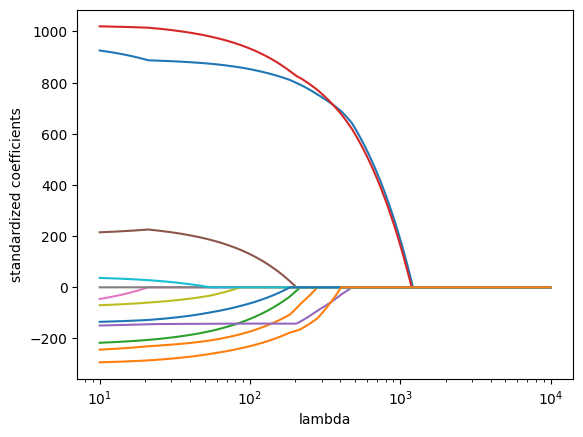

In [19]:
plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("standardized coefficients")
plt.show()

In [20]:
model = Lasso(alpha=1155)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [21]:
model.coef_

array([51.95240235, -0.        , -0.        , 29.23383083, -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        ])

In [22]:
X_dummies.columns

Index(['temp', 'hum', 'windspeed', 'days_since_2011', 'seasonWINTER',
       'seasonSPRING', 'seasonSUMMER', 'seasonFALL', 'holidayHOLIDAY',
       'workingdayWORKING DAY', 'weathersitMISTY',
       'weathersitRAIN/SNOW/STORM'],
      dtype='object')

In [23]:
model = Lasso(alpha=250)
model.fit(X_train, y_train)
model.coef_

array([ 771.93812573,  -31.0663312 ,   -0.        ,  793.68149863,
       -111.5352684 ,    0.        ,    0.        ,   -0.        ,
         -0.        ,    0.        ,   -0.        , -141.88194671])